# Minecraft VLA SFT

Посмотрим на этот [датасет](https://huggingface.co/datasets/CraftJarvis/minecraft-vla-sft)

In [3]:
from datasets import load_dataset

ds = load_dataset("CraftJarvis/minecraft-vla-sft", split="valid", streaming=True)
print(ds.features) 
row = next(iter(ds))


Resolving data files:   0%|          | 0/216 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/216 [00:00<?, ?it/s]

{'id': Value('string'), 'label': List(Value('string')), 'image': List(Value('string')), 'conversations': List({'role': Value('string'), 'content': List({'type': Value('string'), 'text': Value('string')})}), 'image_bytes': List(Value('binary'))}


In [4]:
for key in row:
    print(key, ":", "type ", ": ", type(row[key]))

id : type  :  <class 'str'>
label : type  :  <class 'list'>
image : type  :  <class 'list'>
conversations : type  :  <class 'list'>
image_bytes : type  :  <class 'list'>


По виду он похож на Text Action датасет, но всё же есть отличия в формате данных. Как минимум теперь удобно отформатирован лейбл

In [5]:
label = row['label']
print(label)

['trajectory', 'RT2', 'mine_block:sand', 'h=0', 'c=1']


На сайте датасета через встроенный DuckDB я проверил, что во всех строках содержится trajectory и RT2, так что чего-то другого ожидать не стоит

Теперь можно выделить задачу (atomic task), можно будет фильтровать датасет только по тем задачам и объектам, что мы хотим, скорее всего RT2 отвечает за стиль кодировки действий (какие токены используем), назначение h и c пока не ясно

Из особенностей здесь также подаётся лишь одно изображение на вход, а не последовательность кадров

1


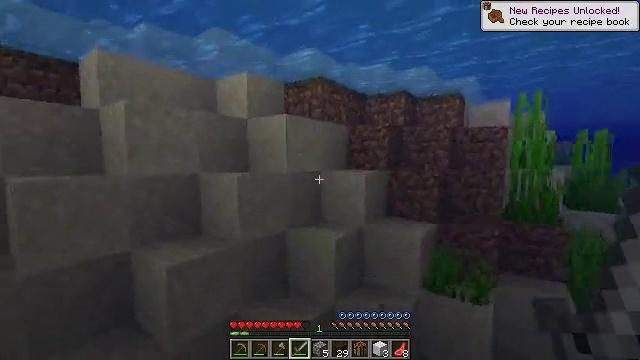

In [6]:
from PIL import Image
from io import BytesIO
image_bytes = row['image_bytes']
print(len(image_bytes))
for bytes in image_bytes:
    img = Image.open(BytesIO(bytes))
    img.show()

Также отличается вывод диалога

In [7]:
import json

conversations = row["conversations"]

print(json.dumps(conversations, indent=2, ensure_ascii=False))


[
  {
    "role": "user",
    "content": [
      {
        "type": "text",
        "text": "Mine sand by the water.\nobservation: \n"
      },
      {
        "type": "image",
        "text": "<image>"
      }
    ]
  },
  {
    "role": "assistant",
    "content": [
      {
        "type": "text",
        "text": "<|reserved_special_token_178|><|reserved_special_token_191|><|reserved_special_token_197|><|reserved_special_token_206|><|reserved_special_token_219|><|reserved_special_token_234|><|reserved_special_token_179|>\n"
      }
    ]
  }
]


Если я правильно понял, то в ответе модели закодирована последовательность действий (какие кнопки нажать, как повернуть камеру) через специальные токены. Также здесь не даётся предварительнный промпт, что должна делать модель и как. Мб промпт уже должен идти по умолчанию во входе, а отсюда убрали для экономии памяти

# Вывод

Такой датасет проще использовать для обучения планированию, чтобы модель по заданному наблюдению и текстовой инструкции выдавала последовательность действий. Как вариант при обучении можно выполнять часть токенов и обновлять наблюдение, чтобы агенту было проще справиться с задачей и он корректировал план исходя из ситуации.

Этот датасет использовался в [статье](https://craftjarvis.github.io/JarvisVLA/files/JARVIS_VLA_paper.pdf) как один из этапов дообучения модели.